### Using AutoKeras 1.0.16.post1 to solve [Dogs vs. Cats Kaggle Competition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview)

In [ ]:
import autokeras as ak
import tensorflow as tf

### Unzip datasets

* train labels: /cat, /dog
* test label: /test (real labels unknown)

In [ ]:
train = ak.image_dataset_from_directory('./train', image_size=(200, 200))
test = ak.image_dataset_from_directory('./test', image_size=(200, 200))

Found 25000 files belonging to 2 classes.
Found 12500 files belonging to 1 classes.


### Train model

In [ ]:
clf = ak.ImageClassifier(max_trials=3, overwrite=True)
clf.fit(train, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Trial 3 Complete [04h 36m 47s]
val_loss: 0.02502167783677578

Best val_loss So Far: 0.02502167783677578
Total elapsed time: 06h 51m 16s
INFO:tensorflow:Oracle triggered exit
Epoch 1/6
Not enough memory, reduce batch size to 16.
Epoch 1/6
Not enough memory, reduce batch size to 8.
Epoch 1/6
Not enough memory, reduce batch size to 4.
Epoch 1/6
6250/6250 [==============================] - 2113s 338ms/step - loss: 0.1483 - accuracy: 0.9423
Epoch 2/6
6250/6250 [==============================] - 2100s 336ms/step - loss: 0.0230 - accuracy: 0.9924
Epoch 3/6
6250/6250 [==============================] - 2101s 336ms/step - loss: 0.0111 - accuracy: 0.9966
Epoch 4/6
6250/6250 [==============================] - 2090s 334ms/step - loss: 0.0088 - accuracy: 0.9972
Epoch 5/6
6250/6250 [==============================] - 2241s 359ms/step - loss: 0.0068 - accuracy: 0.9978
Epoch 6/6
6250/6250 [==============================] - 2087s 334ms/step - loss: 0.0067 - accuracy: 0.9978


C:\Users\Alan\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


* Training time: about 10 hours (using GTX 1660 Ti as GPU)
* Training loss: 0.0067
* Training accuracy: 99.78%

### Predict test labels

In [ ]:
predicted = clf.predict(test)

391/391 [==============================] - 134s 343ms/step


In [ ]:
predicted

array([['cat'],
       ['dog'],
       ['dog'],
       ...,
       ['dog'],
       ['dog'],
       ['dog']], dtype='<U3')

### Print first 40 test images and their predicted labels

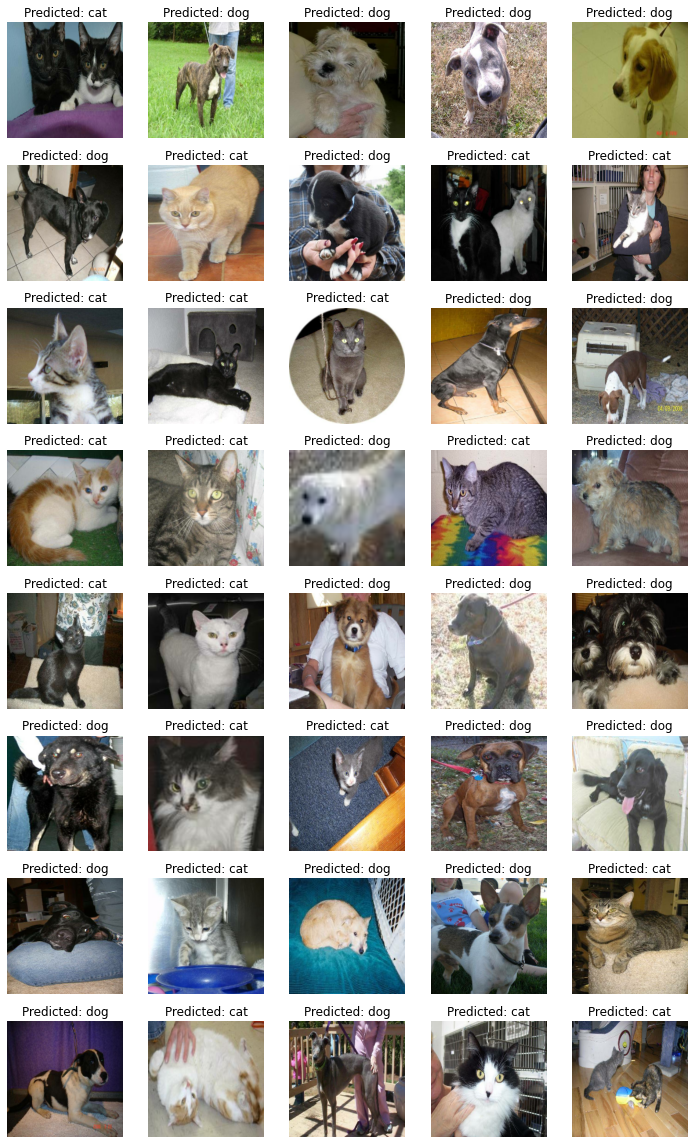

In [ ]:
import matplotlib.pyplot as plt

count = 40
i = 0

fig = plt.figure(figsize=(10, 16))
for batch in test.as_numpy_iterator():
    for img in batch[0]:
        ax = fig.add_subplot(8, 5, i + 1)
        ax.set_title(f'Predicted: {predicted[i][0]}')
        ax.set_axis_off()
        plt.imshow(img / 255)
        i += 1
        if i >= count:
            break
    else:
        continue
    break

plt.tight_layout()
plt.show()

### Inspect model

In [ ]:
model = clf.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 200, 200, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 200, 200, 3)       7         
_________________________________________________________________
random_translation (RandomTr (None, 200, 200, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 200, 200, 3)       0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  640976

### Save best model

In [ ]:
model.save('./catdog_best_model')

C:\Users\Alan\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./catdog_best_model\assets


INFO:tensorflow:Assets written to: ./catdog_best_model\assets


### Load the saved model

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('./catdog_best_model', custom_objects=ak.CUSTOM_OBJECTS)

### Predict labels of 4 new images

In [ ]:
import cv2
import numpy as np

img_original = []
img = []
for i in range(4):
    new_image = cv2.cvtColor(cv2.imread(f'./test{i+1}.jpg'), cv2.COLOR_BGR2RGB)
    img_original.append(new_image)
    img.append(cv2.resize(new_image, (200, 200)))
new_test = np.array(img)

new_predicted = loaded_model.predict(new_test).flatten()
new_predicted

array([0.00111161, 0.99979526, 0.09952653, 0.8113645 ], dtype=float32)

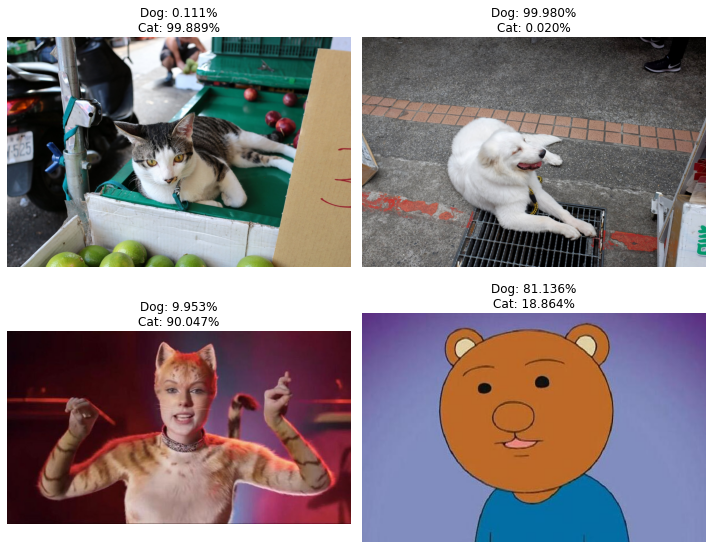

In [ ]:
fig = plt.figure(figsize=(10, 8))

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    plt.imshow(img_original[i])
    ax.set_title(f'Dog: {new_predicted[i]*100:.3f}%\nCat: {(1-new_predicted[i])*100:.3f}%')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

### Predict test labels (again) by order to generate Kaggle submission

In [ ]:
img = []
for i in range(12500):
    new_image = cv2.cvtColor(cv2.imread(f'./test/test/{i+1}.jpg'), cv2.COLOR_BGR2RGB)
    img.append(cv2.resize(new_image, (200, 200)))
test = np.array(img)

predicted = loaded_model.predict(test).flatten()

In [ ]:
import pandas as pd

submission = pd.DataFrame({'id': np.arange(predicted.size)+1, 'label': predicted})
submission

,id,label
0,1,0.999999
1,2,0.999980
2,3,1.000000
3,4,1.000000
4,5,0.000031
...,...,...
12495,12496,0.000001
12496,12497,0.000763
12497,12498,1.000000
12498,12499,1.000000


In [ ]:
submission.to_csv('./submission.csv', index=False)

* Kaggle log loss score: 0.07802